# Introduction to Data Science- The Titanic Problem

In this notebook, I'm going to attempt at breaking down the steps and skills required in solving a data science problem (prediction, analysis, recommendations, etc.) using Python and its scientific packages. I will also walk you through the 'Hello, world!' of Machine Learning problems: Predicting Survival on the sinking RMS Titanic.

## Prerequisites

You must have the following softwares/packages installed to follow along with the tutorial (or tackle any data science problem, for that matter).

* **Jupyter Notebook:** This is the software that lets us run Python code in the browser and intersperse markdown with cells containing code. 
* **Pandas:** This is the data analysis tool of choice in Python. Pandas makes it very easy to work with complex data with incredibly powerful data structures such as dataframes and series.
* **Numpy:** The de facto scientific computing package. Many other libraries such as pandas and sklearn are based on numpy. Numpy gives us access to blistering fast mathematical calculations and makes linear algebra a breeze.
* **Scipy:** The statistical package. Contains an immense number of statistical tools that makes inferential statistical analysis extremely easy. 
* **Scikit-learn:** The machine learning package of Python. Makes implementing ML Algorithms extremely simple. The package has implementations of all the major classifiers and regressors and makes it incredibly simple to switch between different models.
* **Matplotlib:** The data visualisation package of Python. While not as powerful as the packages available in R, it still packs enough power to perform almost every visualisation you could possibly have a need for.
* **Seaborn:** While working with matplotlib, you will eventually realize that implementing a few things become a real pain and the default graphics are rather dull. Seaborn aims at solving both these problems. Built on top of matplotlib, it makes building stunning graphics extremely simple.

You can get access to all the above by downloading the Anaconda distribution. Once you have all your packages in place, import them into your notebook.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## Data Wrangling

The first step in our analysis is data wrangling. Data wrangling refers to the conversion of the raw data that we have into a more usable and suitable form for processes such as training models and analytics. 

In this section of the notebook, we will be doing precisely that. We will be loading our data into a Pandas dataframe, analysing the kind of data we have, cleaning up the unsanitary values and filling/dropping rows wherever necessary. If you're not familiar with the pandas library, now would be a good time to take up a few tutorials.

### Pandas Tutorial Resources
1. **The Official Pandas 10 Minute Tutorial:** https://pandas.pydata.org/pandas-docs/stable/10min.html
2. **Brandon Rhodes' Pandas Tutorial at PyCon 2015:** https://www.youtube.com/watch?v=5JnMutdy6Fw

The resources listed above are my favorites. I had initially found Pandas to be counterintuitive with its filtering, groupby and accessing mechanisms. Rhodes' tutorial absolved that uneasiness for me.

In [2]:
df = pd.read_csv('../input/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We notice that every feature (column) except age, embarked and cabin has non null values. Let us first take care of this. The first step would be to visualise the kind of data we are dealing with. }

Let us deal with the easiest one first: Embarked. Embarked is a categorical variable with only 2 values missing. The most logical way of filling these values would be with the most frequently occuring category. This gives us the highest probability that our guess is right.

In [5]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [6]:
df['Embarked'] = df['Embarked'].fillna('S')

Now, let us move on to age.

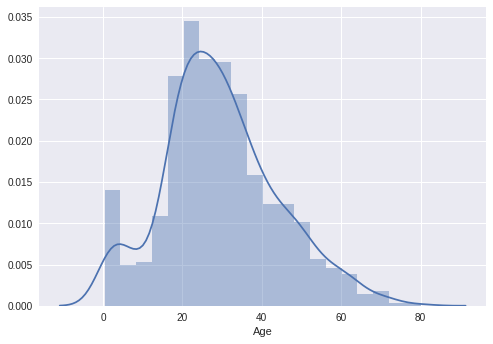

In [7]:
sns.distplot(df[df['Age'].notnull()]['Age'])

In [8]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

We really have no foolproof method of filling in the ages. One naive way of doing it could be by using the mean of the ages (as calculated above). But as the standard deviation is reasonably high, I wouldn't be too keen on doing this. Instead, I'm going to use a very handy method that Pandas provides: interpolation. 

In [9]:
df['Age'] = df['Age'].interpolate()

In [10]:
df['Age'].describe()

count    891.000000
mean      29.726061
std       13.902353
min        0.420000
25%       21.000000
50%       28.500000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

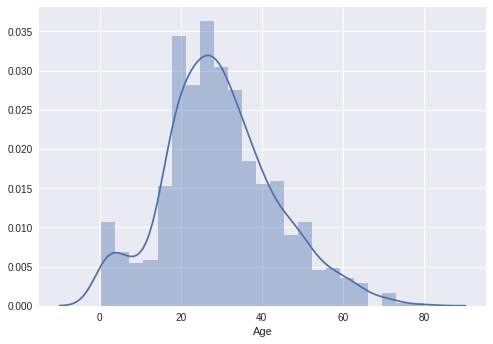

In [11]:
sns.distplot(df['Age'])

As can be seen over here, the Pandas interpolate method has done a pretty good job at preserving the summary statistics and the overall distribution of the ages. We are not very concerned with the slight changes in the mean and the standard deviation. Since this is a classification problem and we will be using decision trees, our classifier will resort to binning the ages, thus nullyfying the quantitative nature of this feature.

Finally, let us move on to the Cabin feature. One thing to notice is that most of the values for the Cabin feature is empty. 

In [12]:
len(df['Cabin'].drop_duplicates())

148

Additionally, we notice that there are 147 different values for Cabin. There is no realistic way of filling in the missing values with so many different possibilities. Add this to the fact that most of the values are empty, we are forced to come to the conclusion that this feature is not of much use to us and therefore, must be dropped.

In [13]:
df = df.drop('Cabin', axis=1)

## Feature Engineering and Data Visualisation

Now that we have a clean dataset, it is time to move on to examining and coming up with new features. In most data science competitions, this is often the most important step. If you engineer you features right and come up with useful insights, you can beat even the most powerful of ensembles.

In this section as the previous, we will be working with the Pandas library. In addition, we will also be working with Matplotlib and Seaborn for the visualisation. 

### Visualisation Tutorials
1. **Seaborn Tutorial:** https://www.datacamp.com/community/tutorials/seaborn-python-tutorial#gs.vL1jfng
2. **Matplotlib Tutorial:** https://matplotlib.org/users/pyplot_tutorial.html

It is not mandatory to go through these resources even if you do not know seaborn. Seaborn is incredibly easy to use with an amazing documentation. So, I'm pretty sure looking up the documentation for all the functions I use will suffice.

The first step of feature engineering is to examine which features are useless to us and drop them. This lets us concentrate on the more important columns and come up with new features which derive their information from these useful columns.

In [14]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


It is not very difficult to see that Passenger ID, Name and Ticket are of no value to us. It is not possible extract any meaningful information out of them. We shall drop these features.

**Note:** If we had a few missing sex values, realize that we could have used the names (more specifically, the salutations) to deduce the gender. But since we already have all non null gender values, it isn't of much use.

In [15]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Let us find the distribution of people in the different classes. Seaborn makes this incredibly easy for us.

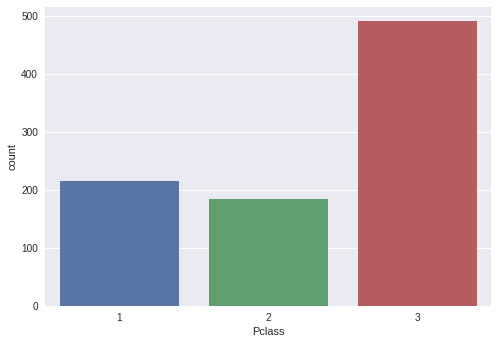

In [16]:
sns.countplot(x='Pclass', data=df)

We can see that the majority of people were in the third class. Based on our intuition and our experience watching the movie, we know that first class passengers were given preference when it came to alloting life boats. Is the probability of survival related to your passenger class? Let us find out by plotting this value.

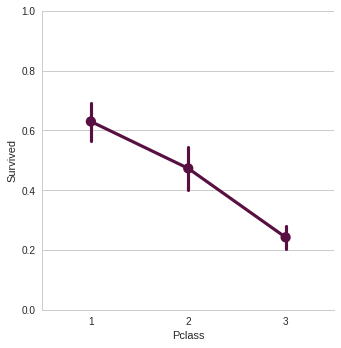

In [17]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=df, x_vars=['Pclass'], y_vars='Survived', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

We see that this is indeed the case. The survival probability decreased as the class decreased. First class passengers were likeliest to survive and the third class passengers were the least likely.

Another adage we are familiar with is the 'Women and Children first' policy to evacuate the ship. This leads us to believe that women and children were more likely to survive as compared to men. We do not have explicit data about children but we can plot the survival probability of men and women as above.

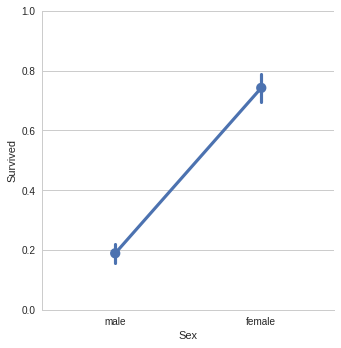

In [18]:
h = sns.PairGrid(data=df, x_vars=['Sex'], y_vars='Survived', size=5)
h.map(sns.pointplot)
h.set(ylim=(0, 1))

We notice that women have almost a 4x better chance of surviving than men. Gender is therefore, a very important feature. As noted earlier, we do not have explicit data about children. But since we have data about the age, we can create a new feature which identifies a passenger as a child.

Let us set the cutoff age at 15. Anyone below the age of 15 will be considered a child.

In [19]:
df['is_child'] = df['Age'].apply(lambda x: 1 if x <= 15 else 0)

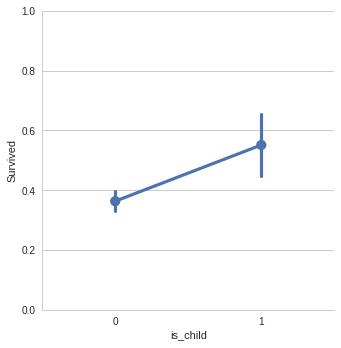

In [20]:
i = sns.PairGrid(data=df, x_vars=['is_child'], y_vars='Survived', size=5)
i.map(sns.pointplot)
i.set(ylim=(0, 1))

There is a slightly better chance you will survive if you are a child. However, the difference is not as drastic as was observed with genders. 

Finally, let us turn our attention to the number of siblings, spouses and children. These are contained as two separate features which does not give us any additional intuitive sense as compared to if it was just one variable.
Let us reduce our dimensions by adding these two variables.

In [21]:
df['family'] = df['SibSp'] + df['Parch']
df = df.drop(['SibSp', 'Parch'], axis=1)

One last feature that we are going to engineer is if the passenger was travelling alone. We could hypothesize that a person traveling alone would have lower chances of surviving as they would have little to no influence on getting a place on a life boat and would most likely belong to a lower class.

In [22]:
df['is_alone'] = df['family'].apply(lambda x: 1 if x == 0 else 0)

Finally, we need to convert our numerical values. Currently, we have two features represented with alphabetic characters: Sex and Embarked.

Let us encode sex in the following way: 1 will represent female and 0 will represent male. To make it more readable, we will call this feature is_female.

In [23]:
df['is_female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df = df.drop('Sex', axis=1)
df.head()

,Survived,Pclass,Age,Fare,Embarked,is_child,family,is_alone,is_female
0,0,3,22.0,7.2500,S,0,1,0,0
1,1,1,38.0,71.2833,C,0,1,0,1
2,1,3,26.0,7.9250,S,0,0,1,1
3,1,1,35.0,53.1000,S,0,1,0,1
4,0,3,35.0,8.0500,S,0,0,1,0


Finally, for the embarked feature, we will perform a process known as **one hot encoding**. This is an extremely potent method to convert categorical variables with a relatively low number of categories. Upon performing one hot encoding, our embarked feature will be replaced with 3 binary variables: **is_S, is_C and is_Q.** This is what our final dataset looks like:

In [24]:
df = pd.get_dummies(df, prefix=['is'])

In [25]:
df.head()

,Survived,Pclass,Age,Fare,is_child,family,is_alone,is_female,is_C,is_Q,is_S
0,0,3,22.0,7.2500,0,1,0,0,0,0,1
1,1,1,38.0,71.2833,0,1,0,1,1,0,0
2,1,3,26.0,7.9250,0,0,1,1,0,0,1
3,1,1,35.0,53.1000,0,1,0,1,0,0,1
4,0,3,35.0,8.0500,0,0,1,0,0,0,1


## Machine Learning

We have now arrived at the prediction part of the analysis. We will be using classifiers from Python's sklearn package. It is important to have a solid understanding of the major regression and classification algorithms (SVM, KNN, K-Means, Decision Trees, Bagging, Boosting, etc.). I strongly recommend going through Harvard's **CS 109- Intro to Data Science** lectures for this purpose. 

### Scikit Learn Resources
1. **Machine Learning with sklearn Part 1:** https://www.youtube.com/watch?v=OB1reY6IX-o&t=5896s
2. **Machine Learning with sklearn Part 2:** https://www.youtube.com/watch?v=Cte8FYCpylk&t=11s

The first step is to split our data into the training data and the labelling class. They are usually denoted as X and y.

In [26]:
X, y = df.drop(['Survived'], axis=1), df['Survived']

Next, we need to be able to test the accuracy of our classifier. In order to do this, we have to split the data available to us into training and test data. I usually take 75% of the data for training and 15% for testing. Feel free to play with the distribution depending on the size of the training data available to you.

Scikit-learn gives us a very handy function to split our data into training and test data.

In [27]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [28]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Our classes seem to be reasonably well balanced. We do not have to resort to methods that counter severe imbalance of classes. We are ready to train our classifier and evaluate its prediction score. The accuracy reported will be a good measure of the performance of our classifier (on account of balanced classes).

Let us train a Decision Tree Classifier first. I will define a method in order to prevent repetition of code when we are trying to test multiple classifiers.

In [29]:
def build_classifier(model):
    classifier = model()
    classifier.fit(train_X, train_y)
    print(classifier.score(test_X, test_y))
    return classifier

In [30]:
decision_tree = build_classifier(GradientBoostingClassifier)

0.856502242152


In [31]:
knn = build_classifier(KNeighborsClassifier)

0.686098654709


I usually use the Gradient Boosting Classifier as my classifier of choice as it tends to yield the best results, on average. We get an average of 80+% accuracy using Gradient Boosting. This is pretty good accuracy (for starters). Improving this accuracy would depend on coming up with newer, better fatures and sometimes applying huge ensembles. These topics will not be covered in this notebook.

What we've covered is pretty basic material. To get really good, you need to know how to visualise your data well. This sometimes requires tools much more advanced than what we've used. Domain knowledge of the competition theme also helps (we came up with the child feature because of our experience watching the Titanic movie). Finalluy, the extra mile is achieved by building strong ensembles and hyperparameter tuning. 

Nevertheless, I hope I've given you a good idea of how the proceedings go in a typical data science competition. The Titanic problem is only scratching the surface. But hopefully, it has provided you good ground and confidence to get started with analysing datasets of your own.